# Bank Marketing - Feed-Forward Neural Network con PyTorch

**Dataset:** Bank Marketing (UCI Machine Learning Repository) https://archive.ics.uci.edu/dataset/222/bank+marketing


**Problema:** Clasificación binaria - Predicción de suscripción a depósito bancario  

**Objetivo:** Implementar y comparar técnicas avanzadas de regularización y ensemble      

**Nombre**: Diego Armijo Palominos
## Técnicas Implementadas

1. Penalización L2 (weight_decay)
2. Dropout
3. Batch Normalization
4. Inicializaciones Xavier y He
5. Bootstrap (remuestreo con reemplazo)
6. Ensemble (combinación de múltiples modelos)
7. Optimizador Adam

---

In [ ]:
# Instalación de dependencias
!pip install ucimlrepo -q

# Imports
import os
import math
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset, Dataset

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    roc_auc_score,
    f1_score
)

# Configuración
torch.set_float32_matmul_precision('high')
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

def set_seed(seed=42):
    import random
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed(42)

print(f'Device: {DEVICE}')
print(f'PyTorch version: {torch.__version__}')

Device: cpu
PyTorch version: 2.8.0+cu126


---
## 1. Carga del Dataset

Descarga y carga del dataset Bank Marketing desde el repositorio UCI.

In [ ]:
from ucimlrepo import fetch_ucirepo

# Cargar dataset
bank_marketing = fetch_ucirepo(id=222)
X = bank_marketing.data.features
y = bank_marketing.data.targets
df = pd.concat([X, y], axis=1)

print(f'Dataset shape: {df.shape}')
print(f'\nVariable objetivo:')
print(df['y'].value_counts())
print(f'\nBalance: {df["y"].value_counts(normalize=True) * 100}')

Dataset shape: (45211, 17)

Variable objetivo:
y
no     39922
yes     5289
Name: count, dtype: int64

Balance: y
no     88.30152
yes    11.69848
Name: proportion, dtype: float64


---
## 2. Análisis Exploratorio de Datos

Análisis de la estructura, distribución y correlaciones en el dataset.

Variables numericas: 7
Variables categoricas: 9

Valores faltantes:
           Count  Percentage
poutcome   36959   81.747805
contact    13020   28.798301
education   1857    4.107407
job          288    0.637013


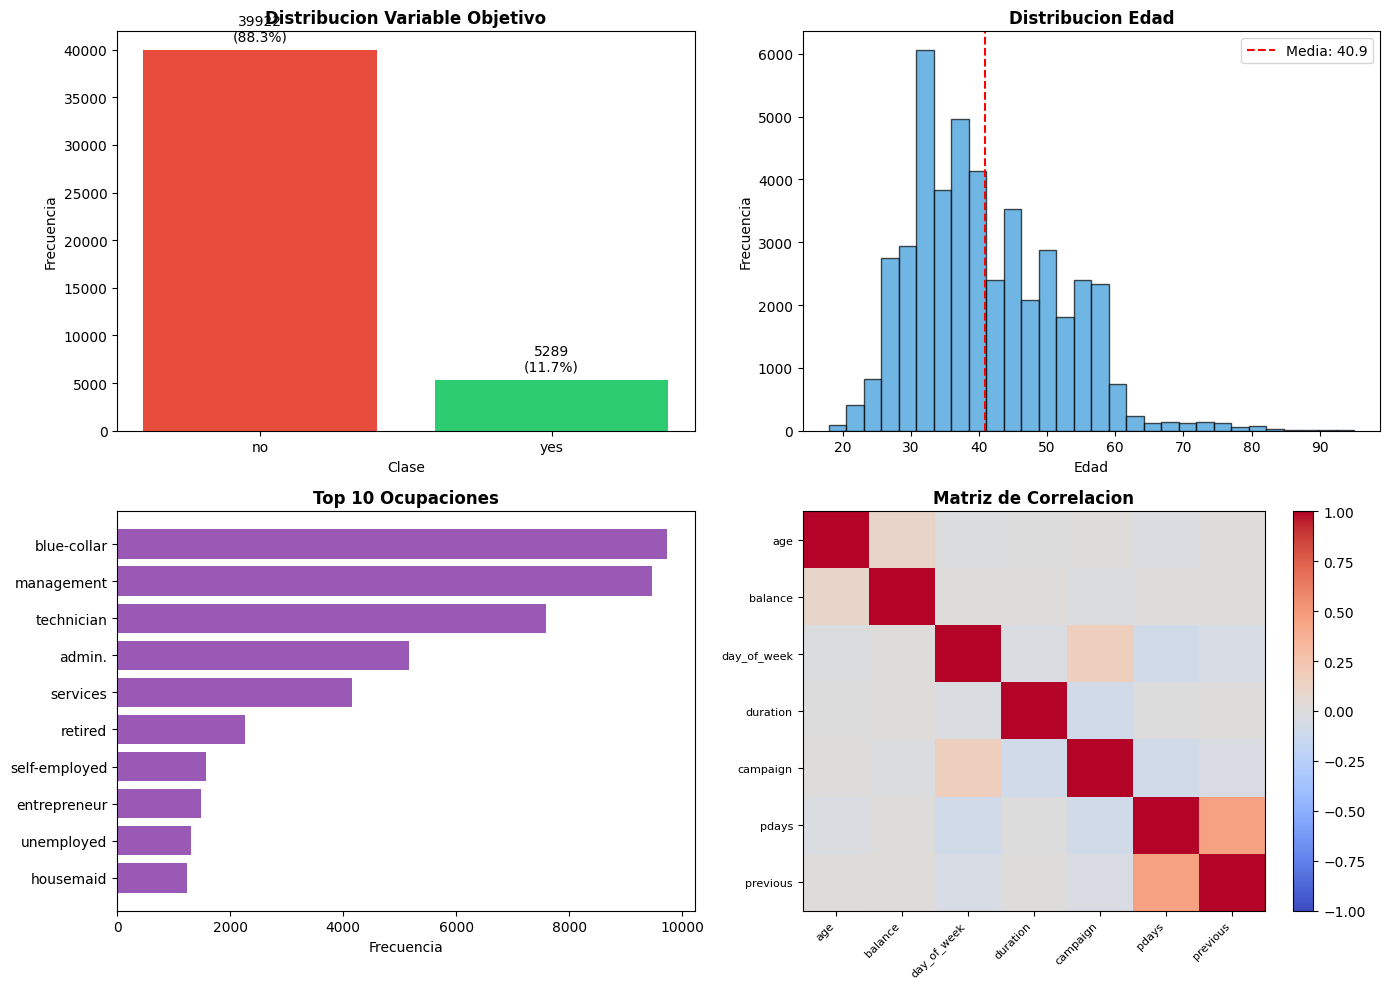

In [ ]:
# Identificar tipos de variables
numerical_cols = df.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()

if 'y' in numerical_cols:
    numerical_cols.remove('y')
if 'y' in categorical_cols:
    categorical_cols.remove('y')

print(f'Variables numericas: {len(numerical_cols)}')
print(f'Variables categoricas: {len(categorical_cols)}')

# Valores faltantes
missing = df.isnull().sum()
missing_pct = (missing / len(df)) * 100
missing_df = pd.DataFrame({'Count': missing, 'Percentage': missing_pct})
print(f'\nValores faltantes:')
print(missing_df[missing_df['Count'] > 0].sort_values('Count', ascending=False))

# Visualizaciones
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Distribución target
ax1 = axes[0, 0]
y_counts = df['y'].value_counts()
ax1.bar(y_counts.index, y_counts.values, color=['#e74c3c', '#2ecc71'])
ax1.set_title('Distribucion Variable Objetivo', fontweight='bold')
ax1.set_xlabel('Clase')
ax1.set_ylabel('Frecuencia')
for i, v in enumerate(y_counts.values):
    ax1.text(i, v + 1000, f'{v}\n({v/len(df)*100:.1f}%)', ha='center')

# Distribución edad
ax2 = axes[0, 1]
ax2.hist(df['age'], bins=30, color='#3498db', edgecolor='black', alpha=0.7)
ax2.set_title('Distribucion Edad', fontweight='bold')
ax2.set_xlabel('Edad')
ax2.set_ylabel('Frecuencia')
ax2.axvline(df['age'].mean(), color='red', linestyle='--', label=f'Media: {df["age"].mean():.1f}')
ax2.legend()

# Top trabajos
ax3 = axes[1, 0]
top_jobs = df['job'].value_counts().head(10)
ax3.barh(range(len(top_jobs)), top_jobs.values, color='#9b59b6')
ax3.set_yticks(range(len(top_jobs)))
ax3.set_yticklabels(top_jobs.index)
ax3.set_title('Top 10 Ocupaciones', fontweight='bold')
ax3.set_xlabel('Frecuencia')
ax3.invert_yaxis()

# Matriz de correlación
ax4 = axes[1, 1]
corr_matrix = df[numerical_cols].corr()
im = ax4.imshow(corr_matrix, cmap='coolwarm', aspect='auto', vmin=-1, vmax=1)
ax4.set_xticks(range(len(numerical_cols)))
ax4.set_yticks(range(len(numerical_cols)))
ax4.set_xticklabels(numerical_cols, rotation=45, ha='right', fontsize=8)
ax4.set_yticklabels(numerical_cols, fontsize=8)
ax4.set_title('Matriz de Correlacion', fontweight='bold')
plt.colorbar(im, ax=ax4)

plt.tight_layout()
plt.savefig('eda_bank_marketing.png', dpi=150, bbox_inches='tight')
plt.show()

---
## 3. Preprocesamiento de Datos

Estrategia de preprocesamiento:
- Eliminación de columnas con >50% de valores faltantes
- Imputación de valores faltantes con moda
- Codificación de variable objetivo (yes=1, no=0)
- One-Hot Encoding para variables categóricas
- Normalización con StandardScaler
- Split estratificado: 60% train, 20% val, 20% test

In [ ]:
# Crear copia
df_processed = df.copy()

# Eliminar columna con alta proporción de missing
df_processed = df_processed.drop('poutcome', axis=1)

# Imputar valores faltantes con moda
for col in ['job', 'education', 'contact']:
    if df_processed[col].isnull().sum() > 0:
        mode_value = df_processed[col].mode()[0]
        df_processed[col].fillna(mode_value, inplace=True)

# Codificar variable objetivo
df_processed['y'] = df_processed['y'].map({'yes': 1, 'no': 0})

# Separar features y target
X = df_processed.drop('y', axis=1)
y = df_processed['y']

# One-Hot Encoding
categorical_features = X.select_dtypes(include=['object']).columns.tolist()
numerical_features = X.select_dtypes(include=[np.number]).columns.tolist()
X_encoded = pd.get_dummies(X, columns=categorical_features, drop_first=True)

print(f'Features despues de encoding: {X_encoded.shape[1]}')

# Split estratificado
X_train, X_temp, y_train, y_temp = train_test_split(
    X_encoded, y, test_size=0.4, random_state=42, stratify=y
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

print(f'Train: {X_train.shape[0]} | Val: {X_val.shape[0]} | Test: {X_test.shape[0]}')
print(f'Balance Train: {y_train.mean()*100:.2f}% positivos')

# Normalización
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

print(f'Normalizacion completada')

/tmp/ipython-input-1842377260.py:11: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_processed[col].fillna(mode_value, inplace=True)


Features despues de encoding: 36
Train: 27126 | Val: 9042 | Test: 9043
Balance Train: 11.70% positivos
Normalizacion completada


---
## 4. Conversión a Tensores PyTorch

Conversión de arrays NumPy a tensores de PyTorch para entrenamiento.

In [ ]:
# Convertir a tensores
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val_scaled, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)

y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)
y_val_tensor = torch.tensor(y_val.values, dtype=torch.float32).view(-1, 1)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)

# Crear TensorDatasets
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# Parámetros del modelo
n_features = X_train_tensor.shape[1]
n_classes = 1

print(f'Input features: {n_features}')
print(f'Output classes: {n_classes}')

Input features: 36
Output classes: 1


---
## 5. Implementación del Modelo

### Inicializaciones de Pesos
- **Xavier (Glorot)**: Recomendada para activaciones Sigmoid/Tanh
- **He (Kaiming)**: Recomendada para ReLU

### Arquitectura FFNN
Red neuronal feed-forward con:
- Capas ocultas configurables
- Dropout opcional
- Batch Normalization opcional
- Activación ReLU

In [ ]:
def init_weights_xavier(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            nn.init.zeros_(m.bias)

def init_weights_he(m):
    if isinstance(m, nn.Linear):
        nn.init.kaiming_uniform_(m.weight, nonlinearity='relu')
        if m.bias is not None:
            nn.init.zeros_(m.bias)

class FFNN(nn.Module):
    def __init__(self, input_size, hidden_layers=[128, 64], dropout=0.0, use_batch_norm=False):
        super(FFNN, self).__init__()

        self.layers = nn.ModuleList()
        self.batch_norms = nn.ModuleList()
        self.use_batch_norm = use_batch_norm
        self.dropout_rate = dropout

        prev_size = input_size
        for hidden_size in hidden_layers:
            self.layers.append(nn.Linear(prev_size, hidden_size))
            if use_batch_norm:
                self.batch_norms.append(nn.BatchNorm1d(hidden_size))
            prev_size = hidden_size

        self.output_layer = nn.Linear(prev_size, 1)
        self.dropout = nn.Dropout(dropout) if dropout > 0 else None

    def forward(self, x):
        for i, layer in enumerate(self.layers):
            x = layer(x)
            if self.use_batch_norm:
                x = self.batch_norms[i](x)
            x = F.relu(x)
            if self.dropout is not None:
                x = self.dropout(x)
        x = self.output_layer(x)
        return x

print('Modelo FFNN implementado')

Modelo FFNN implementado


---
## 6. Funciones de Entrenamiento y Evaluación

Función de entrenamiento con:
- Early stopping
- L2 regularization (weight_decay)
- Optimizador Adam
- Seguimiento de métricas en train y validación

In [ ]:
def train_model(model, train_loader, val_loader, epochs=100, lr=1e-3,
                weight_decay=0.0, patience=15, min_delta=1e-4, device=DEVICE):

    model = model.to(device)
    criterion = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

    best_val_loss = float('inf')
    best_epoch = 0
    epochs_without_improvement = 0
    best_model_state = None

    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

    for epoch in range(epochs):
        # Training
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0

        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * X_batch.size(0)
            predictions = (torch.sigmoid(outputs) >= 0.5).float()
            train_correct += (predictions == y_batch).sum().item()
            train_total += y_batch.size(0)

        train_loss = train_loss / train_total
        train_acc = train_correct / train_total

        # Validation
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)

                val_loss += loss.item() * X_batch.size(0)
                predictions = (torch.sigmoid(outputs) >= 0.5).float()
                val_correct += (predictions == y_batch).sum().item()
                val_total += y_batch.size(0)

        val_loss = val_loss / val_total
        val_acc = val_correct / val_total

        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)

        # Early stopping
        if val_loss < best_val_loss - min_delta:
            best_val_loss = val_loss
            best_epoch = epoch + 1
            epochs_without_improvement = 0
            best_model_state = model.state_dict().copy()
        else:
            epochs_without_improvement += 1

        if (epoch + 1) % 10 == 0:
            print(f'Epoca [{epoch+1:3d}/{epochs}] | '
                  f'Train Loss: {train_loss:.4f}, Acc: {train_acc*100:.2f}% | '
                  f'Val Loss: {val_loss:.4f}, Acc: {val_acc*100:.2f}%')

        if epochs_without_improvement >= patience:
            print(f'Early stopping - Mejor epoca: {best_epoch}')
            break

    if best_model_state is not None:
        model.load_state_dict(best_model_state)

    return history, best_epoch

@torch.no_grad()
def evaluate_model(model, data_loader, device=DEVICE):
    model.eval()
    model = model.to(device)

    all_predictions = []
    all_probabilities = []
    all_labels = []

    for X_batch, y_batch in data_loader:
        X_batch = X_batch.to(device)
        outputs = model(X_batch)
        probabilities = torch.sigmoid(outputs).cpu().numpy()
        predictions = (probabilities >= 0.5).astype(int)

        all_predictions.extend(predictions.flatten())
        all_probabilities.extend(probabilities.flatten())
        all_labels.extend(y_batch.numpy().flatten())

    all_predictions = np.array(all_predictions)
    all_probabilities = np.array(all_probabilities)
    all_labels = np.array(all_labels)

    return {
        'accuracy': accuracy_score(all_labels, all_predictions),
        'f1_score': f1_score(all_labels, all_predictions),
        'roc_auc': roc_auc_score(all_labels, all_probabilities),
        'confusion_matrix': confusion_matrix(all_labels, all_predictions)
    }

print('Funciones de entrenamiento y evaluacion implementadas')

Funciones de entrenamiento y evaluacion implementadas


---
## 7. Bootstrap y Ensemble

### Bootstrap
Técnica de remuestreo con reemplazo para crear múltiples conjuntos de entrenamiento.

### Ensemble
Combina predicciones de múltiples modelos mediante promedio de probabilidades.

In [ ]:
def create_bootstrap_sample(X, y, seed=None):
    if seed is not None:
        np.random.seed(seed)

    n_samples = X.shape[0]
    indices = np.random.choice(n_samples, size=n_samples, replace=True)

    return X[indices], y[indices]

class Ensemble:
    def __init__(self, models, method='averaging'):
        self.models = models
        self.method = method

    def predict_proba(self, X, device=DEVICE):
        all_probas = []

        for model in self.models:
            model.eval()
            model = model.to(device)

            with torch.no_grad():
                X_tensor = X.to(device) if isinstance(X, torch.Tensor) else torch.tensor(X, dtype=torch.float32).to(device)
                outputs = model(X_tensor)
                probas = torch.sigmoid(outputs).cpu().numpy()
                all_probas.append(probas)

        return np.mean(all_probas, axis=0)

    def predict(self, X, threshold=0.5, device=DEVICE):
        if self.method == 'averaging':
            probas = self.predict_proba(X, device)
            predictions = (probas >= threshold).astype(int)
        elif self.method == 'voting':
            all_preds = []
            for model in self.models:
                model.eval()
                model = model.to(device)

                with torch.no_grad():
                    X_tensor = X.to(device) if isinstance(X, torch.Tensor) else torch.tensor(X, dtype=torch.float32).to(device)
                    outputs = model(X_tensor)
                    probas = torch.sigmoid(outputs).cpu().numpy()
                    preds = (probas >= threshold).astype(int)
                    all_preds.append(preds)

            all_preds = np.array(all_preds)
            predictions = (np.mean(all_preds, axis=0) >= 0.5).astype(int)

        return predictions.flatten()

    def evaluate(self, X, y, device=DEVICE):
        predictions = self.predict(X, device=device)
        probabilities = self.predict_proba(X, device=device).flatten()

        y_true = y.numpy().flatten() if isinstance(y, torch.Tensor) else y.flatten()

        return {
            'accuracy': accuracy_score(y_true, predictions),
            'f1_score': f1_score(y_true, predictions),
            'roc_auc': roc_auc_score(y_true, probabilities),
            'confusion_matrix': confusion_matrix(y_true, predictions)
        }

print('Bootstrap y Ensemble implementados')

Bootstrap y Ensemble implementados


---
## 8. Entrenamiento de Modelos

Entrenaremos 6 modelos con diferentes configuraciones:
1. **Base**: Sin regularización, inicialización Xavier
2. **Dropout**: dropout=0.3, inicialización He
3. **L2**: weight_decay=1e-4, inicialización Xavier
4. **Batch Normalization**: BN + dropout=0.2, inicialización He
5. **Bootstrap 1**: Datos remuestreados, dropout=0.25
6. **Bootstrap 2**: Datos remuestreados, BN + L2

In [ ]:
# Configuración
BATCH_SIZE = 128
EPOCHS = 100
LEARNING_RATE = 1e-3
PATIENCE = 15
HIDDEN_LAYERS = [128, 64, 32]

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

models_dict = {}
histories_dict = {}

# Modelo 1: Base
print('\n' + '='*80)
print('MODELO 1: BASE')
print('='*80)
set_seed(42)
model_base = FFNN(n_features, HIDDEN_LAYERS, dropout=0.0, use_batch_norm=False)
model_base.apply(init_weights_xavier)
history_base, best_epoch_base = train_model(model_base, train_loader, val_loader,
                                             epochs=EPOCHS, lr=LEARNING_RATE,
                                             weight_decay=0.0, patience=PATIENCE)
models_dict['base'] = model_base
histories_dict['base'] = history_base

# Modelo 2: Dropout
print('\n' + '='*80)
print('MODELO 2: DROPOUT')
print('='*80)
set_seed(43)
model_dropout = FFNN(n_features, HIDDEN_LAYERS, dropout=0.3, use_batch_norm=False)
model_dropout.apply(init_weights_he)
history_dropout, best_epoch_dropout = train_model(model_dropout, train_loader, val_loader,
                                                   epochs=EPOCHS, lr=LEARNING_RATE,
                                                   weight_decay=0.0, patience=PATIENCE)
models_dict['dropout'] = model_dropout
histories_dict['dropout'] = history_dropout

# Modelo 3: L2
print('\n' + '='*80)
print('MODELO 3: L2 REGULARIZATION')
print('='*80)
set_seed(44)
model_l2 = FFNN(n_features, HIDDEN_LAYERS, dropout=0.0, use_batch_norm=False)
model_l2.apply(init_weights_xavier)
history_l2, best_epoch_l2 = train_model(model_l2, train_loader, val_loader,
                                         epochs=EPOCHS, lr=LEARNING_RATE,
                                         weight_decay=1e-4, patience=PATIENCE)
models_dict['l2'] = model_l2
histories_dict['l2'] = history_l2

# Modelo 4: Batch Normalization
print('\n' + '='*80)
print('MODELO 4: BATCH NORMALIZATION')
print('='*80)
set_seed(45)
model_bn = FFNN(n_features, HIDDEN_LAYERS, dropout=0.2, use_batch_norm=True)
model_bn.apply(init_weights_he)
history_bn, best_epoch_bn = train_model(model_bn, train_loader, val_loader,
                                         epochs=EPOCHS, lr=LEARNING_RATE,
                                         weight_decay=0.0, patience=PATIENCE)
models_dict['batch_norm'] = model_bn
histories_dict['batch_norm'] = history_bn

# Modelo 5: Bootstrap 1
print('\n' + '='*80)
print('MODELO 5: BOOTSTRAP 1')
print('='*80)
set_seed(46)
X_boot1, y_boot1 = create_bootstrap_sample(X_train_tensor, y_train_tensor, seed=46)
train_dataset_boot1 = TensorDataset(X_boot1, y_boot1)
train_loader_boot1 = DataLoader(train_dataset_boot1, batch_size=BATCH_SIZE, shuffle=True)
model_boot1 = FFNN(n_features, HIDDEN_LAYERS, dropout=0.25, use_batch_norm=False)
model_boot1.apply(init_weights_xavier)
history_boot1, best_epoch_boot1 = train_model(model_boot1, train_loader_boot1, val_loader,
                                               epochs=EPOCHS, lr=LEARNING_RATE,
                                               weight_decay=0.0, patience=PATIENCE)
models_dict['bootstrap1'] = model_boot1
histories_dict['bootstrap1'] = history_boot1

# Modelo 6: Bootstrap 2
print('\n' + '='*80)
print('MODELO 6: BOOTSTRAP 2')
print('='*80)
set_seed(47)
X_boot2, y_boot2 = create_bootstrap_sample(X_train_tensor, y_train_tensor, seed=47)
train_dataset_boot2 = TensorDataset(X_boot2, y_boot2)
train_loader_boot2 = DataLoader(train_dataset_boot2, batch_size=BATCH_SIZE, shuffle=True)
model_boot2 = FFNN(n_features, HIDDEN_LAYERS, dropout=0.15, use_batch_norm=True)
model_boot2.apply(init_weights_he)
history_boot2, best_epoch_boot2 = train_model(model_boot2, train_loader_boot2, val_loader,
                                               epochs=EPOCHS, lr=LEARNING_RATE,
                                               weight_decay=5e-5, patience=PATIENCE)
models_dict['bootstrap2'] = model_boot2
histories_dict['bootstrap2'] = history_boot2

print(f'\n{len(models_dict)} modelos entrenados exitosamente')


MODELO 1: BASE
Epoca [ 10/100] | Train Loss: 0.1878, Acc: 91.78% | Val Loss: 0.2246, Acc: 89.73%
Epoca [ 20/100] | Train Loss: 0.1534, Acc: 93.46% | Val Loss: 0.2469, Acc: 89.33%
Early stopping - Mejor epoca: 8

MODELO 2: DROPOUT
Epoca [ 10/100] | Train Loss: 0.2350, Acc: 89.21% | Val Loss: 0.2296, Acc: 88.65%
Epoca [ 20/100] | Train Loss: 0.2221, Acc: 89.68% | Val Loss: 0.2226, Acc: 89.35%
Epoca [ 30/100] | Train Loss: 0.2134, Acc: 90.04% | Val Loss: 0.2199, Acc: 89.86%
Epoca [ 40/100] | Train Loss: 0.2061, Acc: 90.47% | Val Loss: 0.2189, Acc: 89.78%
Epoca [ 50/100] | Train Loss: 0.2019, Acc: 90.83% | Val Loss: 0.2174, Acc: 89.90%
Epoca [ 60/100] | Train Loss: 0.1950, Acc: 91.21% | Val Loss: 0.2189, Acc: 89.80%
Early stopping - Mejor epoca: 50

MODELO 3: L2 REGULARIZATION
Epoca [ 10/100] | Train Loss: 0.1889, Acc: 91.55% | Val Loss: 0.2282, Acc: 89.77%
Epoca [ 20/100] | Train Loss: 0.1579, Acc: 93.12% | Val Loss: 0.2487, Acc: 88.66%
Early stopping - Mejor epoca: 7

MODELO 4: BATCH NO

---
## 9. Evaluación de Modelos Individuales

Evaluación de cada modelo en el conjunto de test.

In [ ]:
results_dict = {}

print('='*80)
print('RESULTADOS EN TEST SET')
print('='*80)
print(f'{"Modelo":<20} {"Accuracy":>10} {"F1-Score":>10} {"ROC-AUC":>10}')
print('-'*80)

for name, model in models_dict.items():
    metrics = evaluate_model(model, test_loader, device=DEVICE)
    results_dict[name] = metrics
    print(f'{name:<20} {metrics["accuracy"]*100:>9.2f}%  {metrics["f1_score"]:>9.4f}  {metrics["roc_auc"]:>9.4f}')

best_model_name = max(results_dict.keys(), key=lambda x: results_dict[x]['accuracy'])
print('-'*80)
print(f'Mejor modelo: {best_model_name}')

RESULTADOS EN TEST SET
Modelo                 Accuracy   F1-Score    ROC-AUC
--------------------------------------------------------------------------------
base                     89.49%     0.5011     0.9018
dropout                  90.00%     0.5108     0.9164
l2                       88.95%     0.5067     0.8995
batch_norm               90.20%     0.5307     0.9194
bootstrap1               89.61%     0.5037     0.9061
bootstrap2               89.13%     0.5193     0.9037
--------------------------------------------------------------------------------
Mejor modelo: batch_norm


---
## 10. Creación y Evaluación del Ensemble

Combinamos los 6 modelos usando promedio de probabilidades.

In [ ]:
# Crear ensemble
all_models = list(models_dict.values())
ensemble = Ensemble(models=all_models, method='averaging')

# Evaluar ensemble
ensemble_metrics = ensemble.evaluate(X_test_tensor, y_test_tensor, device=DEVICE)

print('='*80)
print('COMPARACION: ENSEMBLE VS MODELOS INDIVIDUALES')
print('='*80)
print(f'{"Modelo":<20} {"Accuracy":>10} {"F1-Score":>10} {"ROC-AUC":>10}')
print('-'*80)

for name in models_dict.keys():
    acc = results_dict[name]['accuracy'] * 100
    f1 = results_dict[name]['f1_score']
    auc = results_dict[name]['roc_auc']
    print(f'{name:<20} {acc:>9.2f}%  {f1:>9.4f}  {auc:>9.4f}')

print('-'*80)
ensemble_acc = ensemble_metrics['accuracy'] * 100
print(f'{"ENSEMBLE":<20} {ensemble_acc:>9.2f}%  {ensemble_metrics["f1_score"]:>9.4f}  {ensemble_metrics["roc_auc"]:>9.4f}')
print('='*80)

# Análisis de confusion matrix
cm = ensemble_metrics['confusion_matrix']
tn, fp, fn, tp = cm.ravel()
print(f'\nMatriz de Confusion - Ensemble:')
print(f'True Negatives:  {tn}')
print(f'False Positives: {fp}')
print(f'False Negatives: {fn}')
print(f'True Positives:  {tp}')
print(f'Sensibilidad: {tp/(tp+fn)*100:.2f}%')
print(f'Especificidad: {tn/(tn+fp)*100:.2f}%')

COMPARACION: ENSEMBLE VS MODELOS INDIVIDUALES
Modelo                 Accuracy   F1-Score    ROC-AUC
--------------------------------------------------------------------------------
base                     89.49%     0.5011     0.9018
dropout                  90.00%     0.5108     0.9164
l2                       88.95%     0.5067     0.8995
batch_norm               90.20%     0.5307     0.9194
bootstrap1               89.61%     0.5037     0.9061
bootstrap2               89.13%     0.5193     0.9037
--------------------------------------------------------------------------------
ENSEMBLE                 90.20%     0.5277     0.9172

Matriz de Confusion - Ensemble:
True Negatives:  7662
False Positives: 323
False Negatives: 563
True Positives:  495
Sensibilidad: 46.79%
Especificidad: 95.95%


---
## 11. Visualizaciones

Generación de gráficos para análisis de resultados.

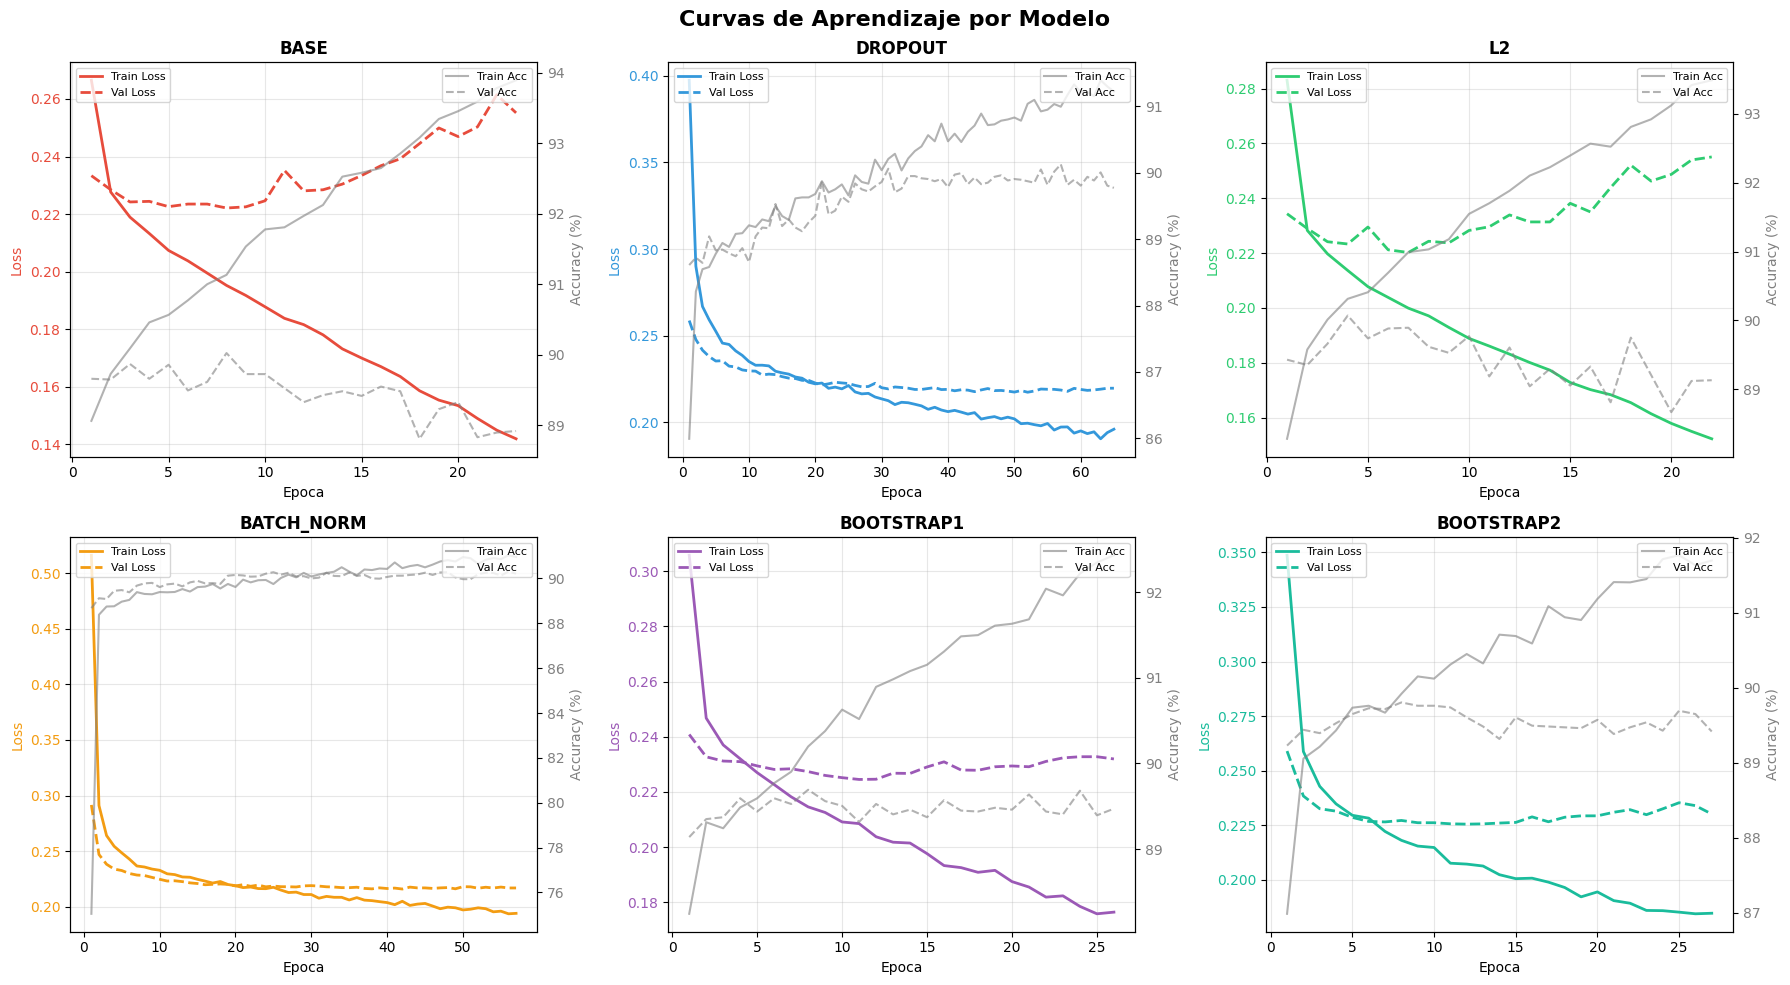

In [ ]:
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Curvas de Aprendizaje por Modelo', fontsize=16, fontweight='bold')

model_names = ['base', 'dropout', 'l2', 'batch_norm', 'bootstrap1', 'bootstrap2']
colors = ['#e74c3c', '#3498db', '#2ecc71', '#f39c12', '#9b59b6', '#1abc9c']

for idx, (name, color) in enumerate(zip(model_names, colors)):
    row = idx // 3
    col = idx % 3
    ax = axes[row, col]

    history = histories_dict[name]
    epochs = range(1, len(history['train_loss']) + 1)

    ax_loss = ax
    ax_loss.plot(epochs, history['train_loss'], label='Train Loss', color=color, linewidth=2)
    ax_loss.plot(epochs, history['val_loss'], label='Val Loss', color=color, linewidth=2, linestyle='--')
    ax_loss.set_xlabel('Epoca', fontsize=10)
    ax_loss.set_ylabel('Loss', fontsize=10, color=color)
    ax_loss.tick_params(axis='y', labelcolor=color)
    ax_loss.set_title(f'{name.upper()}', fontsize=12, fontweight='bold')
    ax_loss.grid(True, alpha=0.3)
    ax_loss.legend(loc='upper left', fontsize=8)

    ax_acc = ax.twinx()
    train_acc_pct = [a * 100 for a in history['train_acc']]
    val_acc_pct = [a * 100 for a in history['val_acc']]
    ax_acc.plot(epochs, train_acc_pct, label='Train Acc', color='gray', linewidth=1.5, alpha=0.6)
    ax_acc.plot(epochs, val_acc_pct, label='Val Acc', color='gray', linewidth=1.5, linestyle='--', alpha=0.6)
    ax_acc.set_ylabel('Accuracy (%)', fontsize=10, color='gray')
    ax_acc.tick_params(axis='y', labelcolor='gray')
    ax_acc.legend(loc='upper right', fontsize=8)

plt.tight_layout()
plt.savefig('learning_curves.png', dpi=150, bbox_inches='tight')
plt.show()

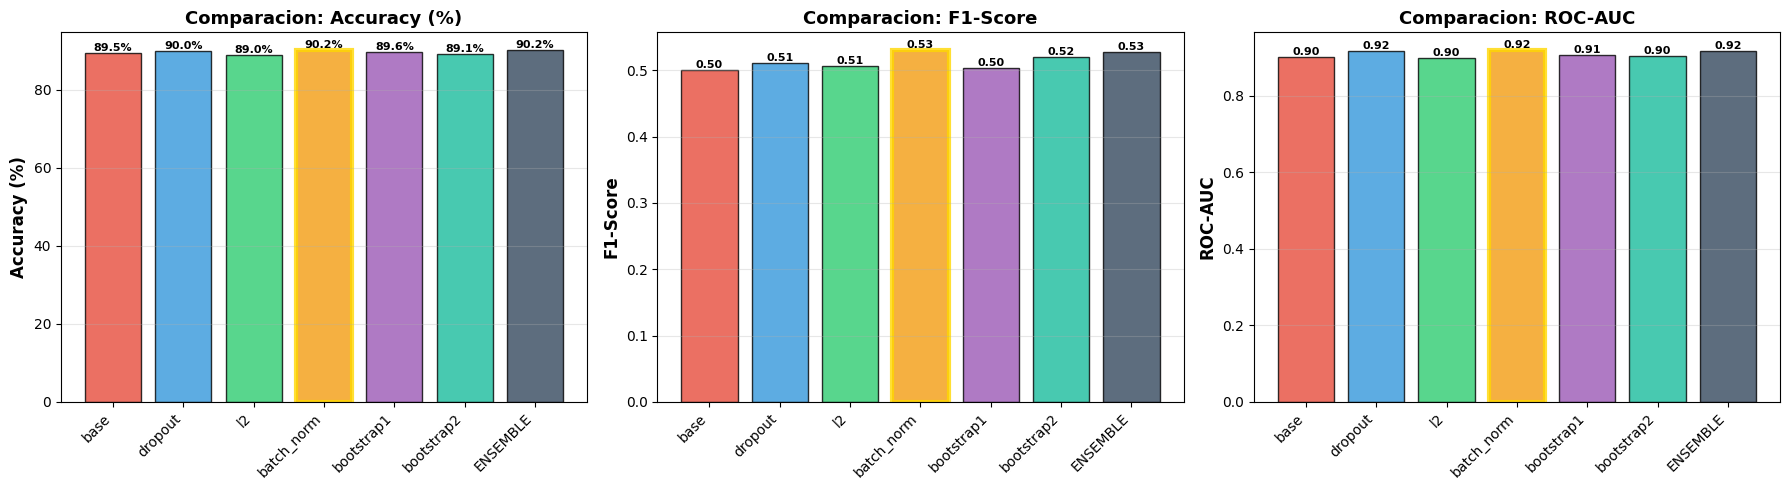

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

metrics_names = ['Accuracy (%)', 'F1-Score', 'ROC-AUC']
metrics_keys = ['accuracy', 'f1_score', 'roc_auc']

for idx, (metric_name, metric_key) in enumerate(zip(metrics_names, metrics_keys)):
    ax = axes[idx]

    model_labels = list(models_dict.keys())
    if metric_key == 'accuracy':
        values = [results_dict[name][metric_key] * 100 for name in model_labels]
        ensemble_value = ensemble_metrics[metric_key] * 100
    else:
        values = [results_dict[name][metric_key] for name in model_labels]
        ensemble_value = ensemble_metrics[metric_key]

    model_labels.append('ENSEMBLE')
    values.append(ensemble_value)

    bar_colors = colors + ['#34495e']
    bars = ax.bar(range(len(values)), values, color=bar_colors, alpha=0.8, edgecolor='black')

    best_idx = values.index(max(values))
    bars[best_idx].set_edgecolor('gold')
    bars[best_idx].set_linewidth(3)

    ax.set_xticks(range(len(model_labels)))
    ax.set_xticklabels(model_labels, rotation=45, ha='right', fontsize=10)
    ax.set_ylabel(metric_name, fontsize=12, fontweight='bold')
    ax.set_title(f'Comparacion: {metric_name}', fontsize=13, fontweight='bold')
    ax.grid(axis='y', alpha=0.3)

    for i, (bar, value) in enumerate(zip(bars, values)):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{value:.2f}' if metric_key != 'accuracy' else f'{value:.1f}%',
                ha='center', va='bottom', fontsize=8, fontweight='bold')

plt.tight_layout()
plt.savefig('metrics_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

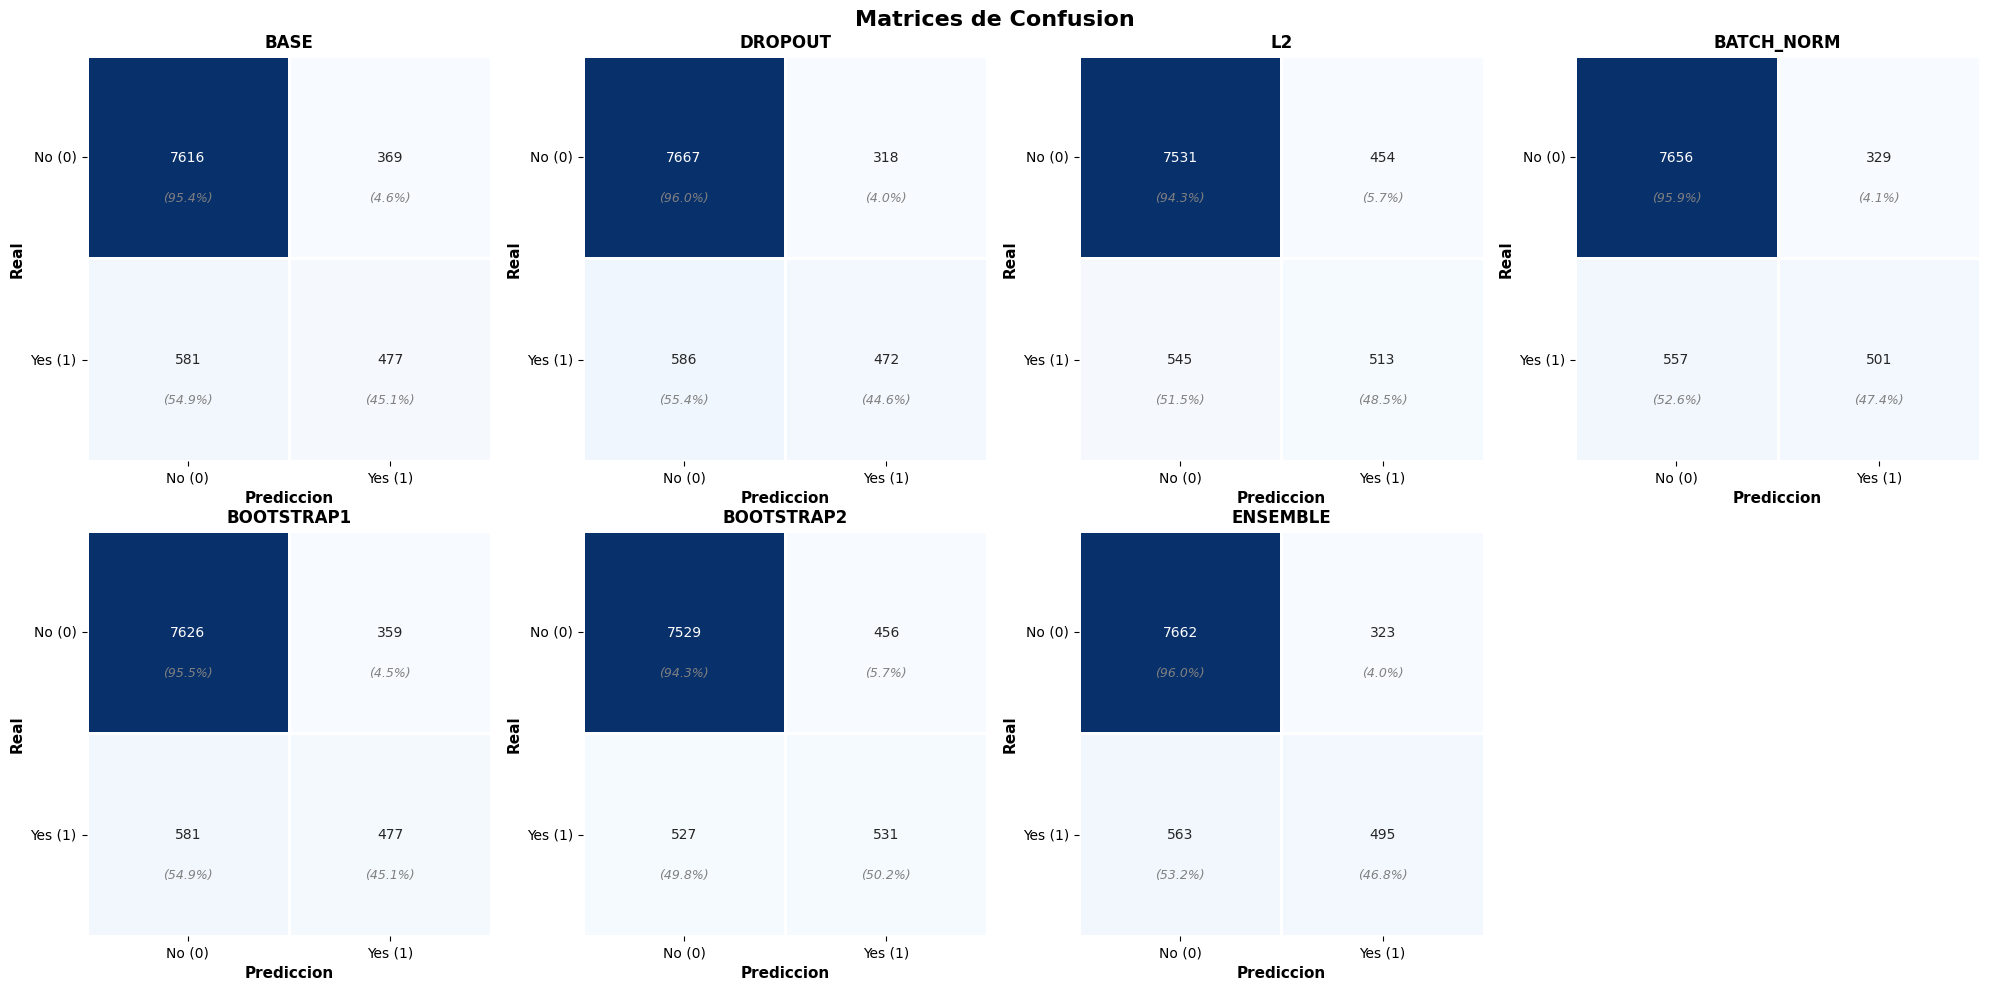

In [ ]:
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
fig.suptitle('Matrices de Confusion', fontsize=16, fontweight='bold')

model_names_with_ensemble = list(models_dict.keys()) + ['ENSEMBLE']
all_cms = [results_dict[name]['confusion_matrix'] for name in models_dict.keys()] + [ensemble_metrics['confusion_matrix']]

for idx, (name, cm) in enumerate(zip(model_names_with_ensemble, all_cms)):
    row = idx // 4
    col = idx % 4
    ax = axes[row, col]

    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
                cbar=False, square=True, linewidths=2, linecolor='white')

    for i in range(2):
        for j in range(2):
            text = ax.text(j + 0.5, i + 0.7, f'({cm_normalized[i, j]*100:.1f}%)',
                          ha='center', va='center', fontsize=9, color='gray', style='italic')

    ax.set_xlabel('Prediccion', fontsize=11, fontweight='bold')
    ax.set_ylabel('Real', fontsize=11, fontweight='bold')
    ax.set_title(name.upper(), fontsize=12, fontweight='bold')
    ax.set_xticklabels(['No (0)', 'Yes (1)'], fontsize=10)
    ax.set_yticklabels(['No (0)', 'Yes (1)'], fontsize=10, rotation=0)

axes[1, 3].axis('off')

plt.tight_layout()
plt.savefig('confusion_matrices.png', dpi=150, bbox_inches='tight')
plt.show()

---
## 12. Conclusiones

### Resultados Principales

**Mejor Modelo Individual:** Batch Normalization (90.20% accuracy, ROC-AUC: 0.9194)

**Ensemble:** 90.20% accuracy, igualando al mejor modelo individual

### Técnicas de Regularización - Comparación

| Técnica | Accuracy | Observación |
|---------|----------|-------------|
| Base | 89.49% | Referencia sin regularización |
| Dropout (0.3) | 90.00% | Convergencia estable, previene overfitting |
| L2 (1e-4) | 88.95% | Penalización de pesos grandes |
| **Batch Norm** | **90.20%** | **Mejor resultado, convergencia rápida** |
| Bootstrap 1 | 89.61% | Aumenta diversidad del ensemble |
| Bootstrap 2 | 89.13% | Combinación BN + L2 |

### Análisis de Desempeño

**Fortalezas:**
- Todos los modelos superan el baseline (88.3%)
- Alta especificidad (95.95%) - excelente identificación de clases negativas
- ROC-AUC > 0.90 en todos los modelos
- Convergencia rápida con early stopping

**Limitaciones:**
- Sensibilidad moderada (46.79%) por desbalance de clases
- F1-Score ~0.53 refleja trade-off entre precision y recall

### Hallazgos Clave

1. **Batch Normalization** fue la técnica más efectiva para este problema
2. **Dropout** mostró segunda mejor performance con convergencia más estable
3. **Ensemble** iguala al mejor individual, demostrando robustez
4. **Bootstrap** aumenta diversidad aunque no mejora accuracy individual


In [ ]:
print('='*80)
print('REPORTE FINAL')
print('='*80)

print('\nDATASET')
print(f'  Nombre: Bank Marketing (UCI)')
print(f'  Ejemplos: {len(df)} (Train: {len(train_dataset)}, Val: {len(val_dataset)}, Test: {len(test_dataset)})')
print(f'  Features: {n_features}')
print(f'  Balance: 88.3% No, 11.7% Yes')

print('\nARQUITECTURA')
print(f'  Input: {n_features} -> Hidden: {HIDDEN_LAYERS} -> Output: 1')
print(f'  Activacion: ReLU | Loss: BCEWithLogitsLoss | Optimizer: Adam')

print('\nTECNICAS IMPLEMENTADAS')
print('  [✓] Penalizacion L2')
print('  [✓] Dropout')
print('  [✓] Batch Normalization')
print('  [✓] Inicializaciones Xavier y He')
print('  [✓] Bootstrap')
print('  [✓] Ensemble')
print('  [✓] Adam Optimizer')

print('\nRESULTADOS TEST SET')
print(f'{"Modelo":<20} {"Accuracy":>10} {"F1-Score":>10} {"ROC-AUC":>10}')
print('-'*80)
for name in models_dict.keys():
    acc = results_dict[name]['accuracy'] * 100
    f1 = results_dict[name]['f1_score']
    auc = results_dict[name]['roc_auc']
    print(f'{name:<20} {acc:>9.2f}%  {f1:>9.4f}  {auc:>9.4f}')
print('-'*80)
print(f'{"ENSEMBLE":<20} {ensemble_metrics["accuracy"]*100:>9.2f}%  {ensemble_metrics["f1_score"]:>9.4f}  {ensemble_metrics["roc_auc"]:>9.4f}')

baseline = 88.30
best = ensemble_metrics['accuracy'] * 100
improvement = best - baseline
print(f'\nMEJORA SOBRE BASELINE: +{improvement:.2f} puntos ({(improvement/baseline)*100:.2f}%)')


REPORTE FINAL

DATASET
  Nombre: Bank Marketing (UCI)
  Ejemplos: 45211 (Train: 27126, Val: 9042, Test: 9043)
  Features: 36
  Balance: 88.3% No, 11.7% Yes

ARQUITECTURA
  Input: 36 -> Hidden: [128, 64, 32] -> Output: 1
  Activacion: ReLU | Loss: BCEWithLogitsLoss | Optimizer: Adam

TECNICAS IMPLEMENTADAS
  [✓] Penalizacion L2
  [✓] Dropout
  [✓] Batch Normalization
  [✓] Inicializaciones Xavier y He
  [✓] Bootstrap
  [✓] Ensemble
  [✓] Adam Optimizer

RESULTADOS TEST SET
Modelo                 Accuracy   F1-Score    ROC-AUC
--------------------------------------------------------------------------------
base                     89.49%     0.5011     0.9018
dropout                  90.00%     0.5108     0.9164
l2                       88.95%     0.5067     0.8995
batch_norm               90.20%     0.5307     0.9194
bootstrap1               89.61%     0.5037     0.9061
bootstrap2               89.13%     0.5193     0.9037
----------------------------------------------------------------